In [1]:
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!mkdir training
%cd training

mkdir: training: File exists
/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training


In [3]:
# 下载yolov5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# 安装依赖
%pip install -r requirements.txt  # install dependencies
%cd ../

# %pip install --upgrade torch 
# %pip install --upgrade torchvision

import torch
import torchvision

print(f"Setup complete. Using torch {torch.__version__}, torchvision {torchvision.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training
Setup complete. Using torch 2.2.2, torchvision 0.17.2 (CPU)


In [4]:
## 利用tensorboard将日志保存到"yolov5/runs"中（但是在kaggle中使用它有问题，故后续使用wandb）
%load_ext tensorboard
%tensorboard --logdir /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/runs

Reusing TensorBoard on port 6006 (pid 85860), started 1:11:21 ago. (Use '!kill 85860' to kill it.)

In [5]:
# Install W&B 
%pip install -q --upgrade wandb
# 登录wandb在线可视化工具（如果有联网问题yolov5也可使用tensorboard）
import wandb
wandb.login()

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


wandb: Currently logged in as: gauvaine107 (gauvaine107-china). Use `wandb login --relogin` to force relogin


True

In [6]:
# Import lib
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import yaml
from shutil import copyfile
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training
%ls 

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training
cowboy/    train.csv  yolo_anno/ yolov5/


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# 将边界框从coco格式转为yolo格式
1.将train.json文件转为train.csv文件（id-filename)  
2.将训练图像的标注框格式从coco转为yolo

In [8]:
# 读取json文件
json_file_path = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/train.json'

data = json.load(open(json_file_path, 'r'))
yolo_anno_path = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolo_anno/'

if not os.path.exists(yolo_anno_path):
    os.makedirs(yolo_anno_path)

In [9]:
# 本次比赛中，train.json 中提供的 categories_id 不是一个连续的数字，需要重新映射它，否则会出错
# annotation lable不连续，故重新生成一个映射
cate_id_map = {}
num = 0
for cate in data['categories']:
    cate_id_map[cate['id']] = num
    num+=1

In [10]:
cate_id_map

{87: 0, 1034: 1, 131: 2, 318: 3, 588: 4}

In [11]:
# 对比
data['categories']

[{'id': 87, 'name': 'belt', 'freebase_id': '/m/0176mf'},
 {'id': 1034, 'name': 'sunglasses', 'freebase_id': '/m/017ftj'},
 {'id': 131, 'name': 'boot', 'freebase_id': '/m/01b638'},
 {'id': 318, 'name': 'cowboy_hat', 'freebase_id': '/m/025rp__'},
 {'id': 588, 'name': 'jacket', 'freebase_id': '/m/032b3c'}]

In [12]:
def cc2yolo_bbox(img_width, img_height, bbox):
    dw = 1. / img_width
    dh = 1. / img_height
    x = bbox[0] + bbox[2] / 2.0
    y = bbox[1] + bbox[3] / 2.0
    w = bbox[2]
    h = bbox[3]
 
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

In [13]:
# 生成train.csv文件（imgid-filename)
# 将训练图像的标注框格式从coco转为yolo，存在yolo_anno文件夹中（每张训练图像的类别和坐标txt文件）
f = open('train.csv','w')
f.write('id,file_name\n')
for i in tqdm(range(len(data['images']))):
    filename = data['images'][i]['file_name']
    img_width = data['images'][i]['width']
    img_height = data['images'][i]['height']
    img_id = data['images'][i]['id']
    yolo_txt_name = filename.split('.')[0] + '.txt' #remove .jpg

    # 将train.json文件转为train.csv文件（imgid-filename)
    f.write('{},{}\n'.format(img_id, filename))
    yolo_txt_file = open(os.path.join(yolo_anno_path, yolo_txt_name), 'w')

    # 将训练图像的标注框格式从coco转为yolo，并将每一张训练图像的类别和坐标存在yolo_anno/filename.txt中
    for anno in data['annotations']:
        if anno['image_id'] == img_id:
            yolo_bbox = cc2yolo_bbox(img_width, img_height, anno['bbox']) # "bbox": [x,y,width,height]        
            yolo_txt_file.write('{} {} {} {} {}\n'.format(cate_id_map[anno['category_id']], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]))
    yolo_txt_file.close()
f.close()

100%|██████████████████████████████████████| 3062/3062 [00:03<00:00, 999.64it/s]


In [14]:
# 查看train.csv文件（imgid-filename）
train = pd.read_csv('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/train.csv')
train.head()

,id,file_name
0,9860841628484337660,88d8bf3754317ffc.jpg
1,15984033263460081658,ddd2b190ea90dffa.jpg
2,76077631043502082,010e4833cdb38002.jpg
3,18065680256228130812,fab6307a1a43fffc.jpg
4,9491379842992996352,83b827ae01e68000.jpg


# 划分训练集和验证集

In [15]:
train_df, valid_df = train_test_split(train, test_size=0.10, random_state=233)
print(f'Size of total training images: {len(train)}, training images: {len(train_df)}. validation images: {len(valid_df)}')

# 说明下，这里给的validation set 就0.01，是因为这次的比赛挑战之一就是数据集很小，还是希望能够给更多的数据来训练。
# 其次，老师已经划分好了validation集了，这里的0.01的验证更多是测试自己算法是否有错误，真正看performance还是提交上去看好。
# 100次的提交也足够验证performance了.

Size of total training images: 3062, training images: 2755. validation images: 307


In [16]:
# 将训练集和验证集合并成一个统一的数据集 df，并为每个样本添加了一个 split 列来标识其所属的集合
train_df.loc[:, 'split'] = 'train'
valid_df.loc[:, 'split'] = 'valid'
df = pd.concat([train_df, valid_df]).reset_index(drop=True)
df.sample(10)

,id,file_name,split
848,13335527374957085208,b9114f7e2cd08218.jpg,train
1517,3831686045059450823,352ce228269707c7.jpg,train
1041,3513638237539795655,30c2f35c69ca02c7.jpg,train
2176,7588102436470489621,694e5af665198215.jpg,train
1301,11534575741337536152,a0130b8621430698.jpg,train
2893,18032421503599653637,fa4007d1522c3305.jpg,valid
1204,8818987140228712858,7a6356143c12099a.jpg,train
2679,10600017241698078804,931ad385206e1054.jpg,train
1289,1703536022502507603,17a42cfc9b580453.jpg,train
1962,49870909914231382,00b12d540e103256.jpg,train


# 生成yolov5所要求的目录格式
/training    --temp_traning space
    /dataset --dataset fold, split into training and validation  
         /images  
         /labels  
    /yolov5  --yolov5 main 
## 注意
YOLOv5 的 data.yaml 文件用于配置数据集的路径和相关信息，其中只需要指定图像路径而不需要明确指定标签路径：  

默认约定: YOLOv5 遵循了一种默认的数据集结构约定。按照这种约定，标签文件与图像文件应该在相同的目录结构下，并且以特定的命名方式命名。通常是将图像文件的扩展名（如 .jpg, .png）替换为 .txt，这样标签文件和对应的图像文件在同一目录下。  

文件关联: YOLOv5 在训练时会自动查找与每张图像相对应的标签文件。它会假设标签文件与图像文件在相同的目录中，并且使用相同的文件名（除了扩展名不同）。这种关联关系使得在 data.yaml 中只需要列出图像文件的路径，而不需要显式指定标签文件的路径。  

简化配置: 简化了配置文件的编写过程。通过不需要显式地指定标签路径，用户可以更加简洁地配置数据集信息，只需指定图像文件夹的路径即可。这种设计使得配置更加清晰和易于管理。  

综上所述，YOLOv5之所以不需要在 data.yaml 中指定标签路径，是因为它依赖于一种约定俗成的文件命名和存储结构，使得训练过程中可以自动地找到每张图像对应的标签文件，从而简化了用户的配置工作。  

In [17]:
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/
%ls

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training
cowboy/    train.csv  yolo_anno/ yolov5/


In [18]:
# 创建训练集和验证集的img和label路径
os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/train', exist_ok=True)
os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/valid', exist_ok=True)

os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/labels/train', exist_ok=True)
os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/labels/valid', exist_ok=True)

%ls

cowboy/    train.csv  yolo_anno/ yolov5/


In [19]:
# 将input的训练集的img和label根据split（train/valid）分别存放到training的imgs和labels中
for i in tqdm(range(len(df))):
    row = df.loc[i]
    name = row.file_name.split('.')[0]
    if row.split == 'train':
        copyfile(f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/images/{name}.jpg', 
                 f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/train/{name}.jpg')
        copyfile(f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolo_anno/{name}.txt', 
                 f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/labels/train/{name}.txt')
    else:
        copyfile(f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/images/{name}.jpg',
                 f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/valid/{name}.jpg')
        copyfile(f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolo_anno/{name}.txt', 
                 f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/labels/valid/{name}.txt')

100%|██████████████████████████████████████| 3062/3062 [00:06<00:00, 439.96it/s]


# 创建.yaml文件

In [20]:
# # 创建.yaml文件
# data_yaml = dict(
#     train = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/train/',
#     val = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/cowboy/images/valid/',
#     nc = 5,
#     names = ['belt', 'sunglasses', 'boot', 'cowboy_hat', 'jacket']
# )

# # 将data.yaml文件存放在yolov5/data目录下
# with open('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/data/data.yaml', 'w') as outfile:
#     yaml.dump(data_yaml, outfile, default_flow_style=True)
    
# %cat /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/data/data.yaml # show your YAML file

# 设置训练超参数

In [21]:
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

In [22]:
#IMG_SIZE = 640  # the default image size in yolo is 640, it will automated resize our image during training and valudation.
BATCH_SIZE = 32
EPOCHS = 5
MODEL = 'yolov5m.pt'  # 5s, 5m 5l
name = f'{MODEL}_BS_{BATCH_SIZE}_EP_{EPOCHS}'

# 开始训练

In [23]:
# 借助w&b可视化训练过程，During training you can open your project webpage to visualize your training process.
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5


由于matplotlib的原因，训练不能在jupyternotebook中进行，但在后端直接运行train.py时能正常训练  
后端训练的结果保存在use_yolov5/training/yolov5/runs/train/exp中  
jupyternotebook如果运行成功则训练结果保存在use_yolov5/working/kaggle-cowboy/{MODEL}_BS_{BATCH_SIZE}_EP_{EPOCHS}中

In [27]:
%matplotlib inline 

In [28]:
!python train.py --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/data/cowboy.yaml \
                 --weights {MODEL} \
                 --save-period 1 \
                 --project /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/kaggle-cowboy \
                 --name {name} \
                 --cache    

Traceback (most recent call last):
  File "/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/train.py", line 47, in <module>
    import val as validate  # for end-of-epoch mAP
  File "/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/val.py", line 39, in <module>
    from models.common import DetectMultiBackend
  File "/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/models/common.py", line 27, in <module>
    import ultralytics
  File "/Users/gauvain/anaconda3/envs/yolov5/lib/python3.9/site-packages/ultralytics/__init__.py", line 10, in <module>
    from ultralytics.data.explorer.explorer import Explorer
  File "/Users/gauvain/anaconda3/envs/yolov5/lib/python3.9/site-packages/ultralytics/data/__init__.py", line 3, in <module>
    from .base import BaseDataset
  File "/Users/gauvain/anaconda3/envs/yolov5/lib/python3.9/site-packages/ul

In [25]:
# !zip -r /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/output.zip /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/kaggle-cowboy

# Inference
推断（inference）阶段是使用已经训练好的模型对新数据进行预测或分类的过程

In [26]:
# In the Dev phase, we will only use the valid data for predicition. 
# Don't forget change it to test data in the Final pahse.
# 这里的验证图像指原先数据集的valid图像，而不是由train图像随机划分的valid图像

valid_df = pd.read_csv('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/valid.csv')
test_df = pd.read_csv('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/test.csv')
valid_df.head()

,id,file_name
0,2817499345625518079,2719c4ba22e78fff.jpg
1,4780409558104969215,42576d2a57ba8fff.jpg
2,7518610131770248858,685778145cd18e9a.jpg
3,9535349983136256004,84545e4a09dd1004.jpg
4,15034561753984241668,d0a57e423be79004.jpg


In [27]:
valid_df.shape

(999, 2)

In [28]:
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/
%ls

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training
cowboy/    train.csv  yolo_anno/ yolov5/


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [29]:
# 创建inference的valid和test目录
os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/valid', exist_ok=True)
os.makedirs('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/test', exist_ok=True)

In [30]:
# 将用于detection过程的验证图像复制到inference/valid中
for i in tqdm(range(len(valid_df))):
    row = valid_df.loc[i]
    name = row.file_name.split('.')[0]
    copyfile(f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/images/{name}.jpg', 
             f'/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/valid/{name}.jpg')

100%|████████████████████████████████████████| 999/999 [00:01<00:00, 603.48it/s]


In [31]:
VALID_PATH = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/valid/'
MODEL_PATH = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboy-object-detection-models/v0_ep20_best.pt'
IMAGE_PATH = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboyoutfits/images/'

# Detection

In [32]:
# 进入yolov5文件夹
%cd /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/

/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5


In [33]:
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.546 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --save-conf \
                  --augment

detect: weights=['/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/input/cowboy-object-detection-models/v0_ep20_best.pt'], source=/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/valid/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.546, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-7-25 Python-3.9.19 torch-2.2.2 CPU

Fusing layers... 
Model summary: 224 layers, 7064698 parameters, 0 gradients
image 1/999 /Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/inference/valid/0007c3f55f707547.jpg: 448x640 1 cowboy_hat, 403.4ms
image 2/999 /Users/gauvain/Desk

In [34]:
# 预测结果的输出路径保存在`training/yolov5/runs/detect/exp/`下
PRED_PATH = '/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/runs/detect/exp/labels/'

# 可视化预测的目标检测图像

In [35]:
with open('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/runs/detect/exp/labels/010fb53ff39a0ea1.txt', 'r') as file:
    for line in file:
        print(line)

1 0.486816 0.566895 0.227539 0.0947266 0.858667



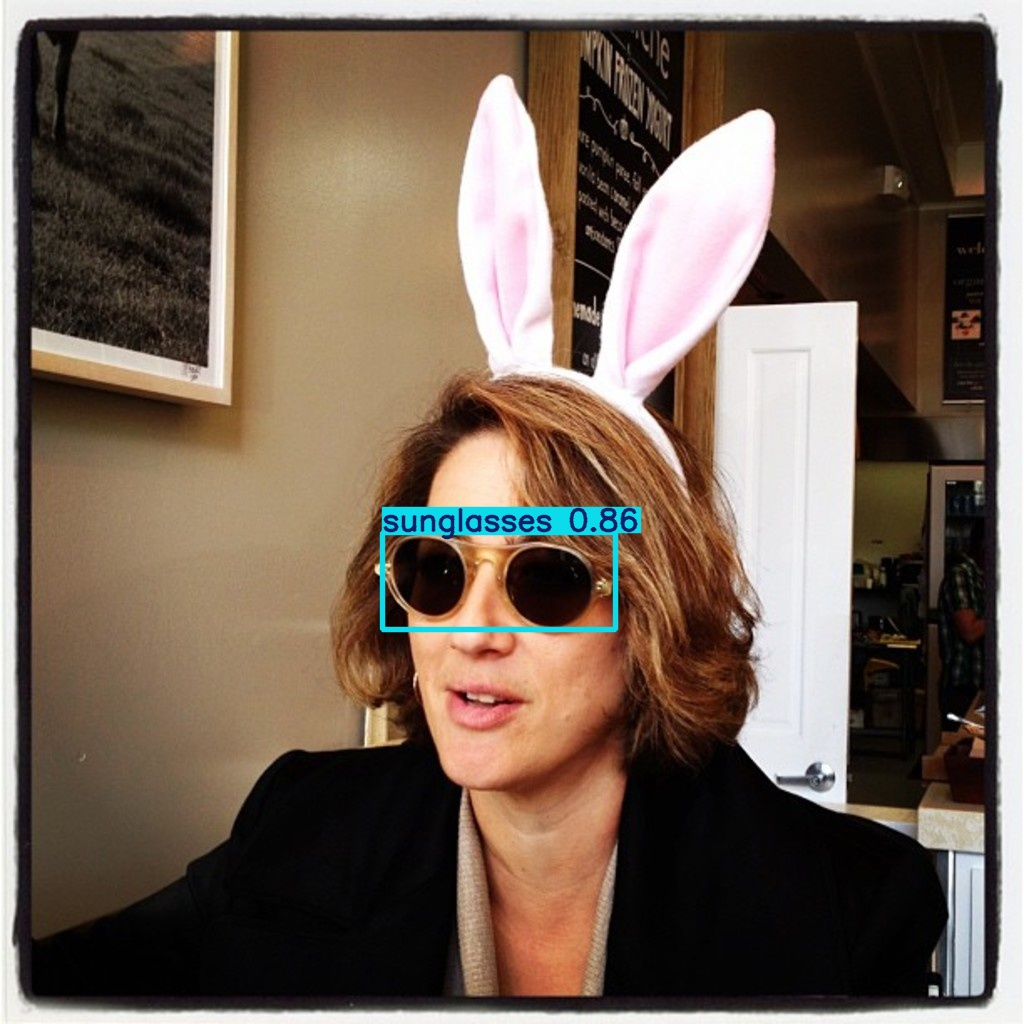

In [36]:
from PIL import Image
Image.open('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/training/yolov5/runs/detect/exp/010fb53ff39a0ea1.jpg')

In [37]:
# valid图像一共有999张，但带有检测目标的图像只有891张
prediction_files = os.listdir(PRED_PATH)
print('Number of test images with detections: ', len(prediction_files))

Number of test images with detections:  891


In [38]:
# 将yolo格式转为coco格式
def yolo2cc_bbox(img_width, img_height, bbox):
    x = (bbox[0] - bbox[2] * 0.5) * img_width
    y = (bbox[1] - bbox[3] * 0.5) * img_height
    w = bbox[2] * img_width
    h = bbox[3] * img_height
    
    return (x, y, w, h)

In [39]:
# 将类别标号还原
re_cate_id_map = dict(zip(cate_id_map.values(), cate_id_map.keys()))

print(re_cate_id_map)

{0: 87, 1: 1034, 2: 131, 3: 318, 4: 588}


In [40]:
def make_submission(df, PRED_PATH, IMAGE_PATH):
    output = []
    for i in tqdm(range(len(df))):
        row = df.loc[i]
        image_id = row['id']
        file_name = row['file_name'].split('.')[0]
        prediction_files = os.listdir(PRED_PATH)
        if f'{file_name}.txt' in prediction_files: # 如果valid的图像包含检测目标，即在prediction_files中
            img = Image.open(f'{IMAGE_PATH}/{file_name}.jpg') # 读取该图像
            width, height = img.size
            with open(f'{PRED_PATH}/{file_name}.txt', 'r') as file:
                for line in file:# 一张图像可能有多个检测目标
                    preds = line.strip('\n').split(' ')
                    preds = list(map(float, preds)) #conver string to float
                    cc_bbox = yolo2cc_bbox(width, height, preds[1:-1])
                    result = {
                        'image_id': image_id,
                        'category_id': re_cate_id_map[preds[0]],
                        'bbox': cc_bbox,
                        'score': preds[-1]
                    }

                    output.append(result)
    return output

In [41]:
sub_data = make_submission(valid_df, PRED_PATH, IMAGE_PATH)

100%|████████████████████████████████████████| 999/999 [00:02<00:00, 374.38it/s]


In [42]:
len(sub_data)

1526

In [43]:
op_pd = pd.DataFrame(sub_data)
op_pd

,image_id,category_id,bbox,score
0,2817499345625518079,131,"(692.0001792, 672.9999872, 50.0000256, 54.9999...",0.570217
1,2817499345625518079,588,"(163.999872, 419.00032, 85.999872, 181.999616)",0.656713
2,2817499345625518079,588,"(52.99967999999999, 413.000192, 144.0, 222.000...",0.691969
3,2817499345625518079,588,"(241.99987199999998, 399.000576, 139.000320000...",0.832395
4,4780409558104969215,588,"(553.000448, 226.999831, 304.0, 434.000056)",0.720573
...,...,...,...,...
1521,17567568607148511222,588,"(685.9996160000001, 340.999804, 318.000128, 38...",0.603668
1522,17567568607148511222,588,"(19.000320000000016, 264.9995615, 266.999808, ...",0.624122
1523,17567568607148511222,588,"(496.99993600000005, 341.00016949999997, 211.9...",0.641105
1524,17567568607148511222,588,"(253.00019199999997, 332.99974, 268.99968, 350...",0.820443


In [44]:
import zipfile 

op_pd.to_json('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/answer.json',orient='records')
zf = zipfile.ZipFile('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/sample_answer.zip', 'w')
zf.write('/Users/gauvain/Desktop/github/Pytorch/kaggle-competition/cowboy_detection/use_yolov5/working/answer.json', 'answer.json')
zf.close()